## Name: Muhammad Umer Farooq
## Student ID: 22402098

# Assignment 3: Class Activation Map
In this assignment we will use the [Class Activation Mapping Technique](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) to demonstrate that object specific spatial information is available in pre-trained image classification networks.

## Introduction:
The final output convolution layers of a trained image classification network contain detailed semantic information about the input image. These feature maps, although low resolution (e.g. 7 x 7) also contain spatial information about the location of the primary object in the image. In the class activation mapping technique we wish to extract this spatial information pertaining to the identified class and overlay this activation on the input image as shown in the figure below.

![](https://github.com/tonyscan6003/etivities/blob/main/cam_img.JPG?raw=true)
























## HouseKeeping
  Import Packages, set batch size and Size of Images input to network.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds

In [3]:
from tensorflow.keras.models import Model, Sequential
import seaborn as sns

In [4]:
# Global Variables
batch_size = 16
HW_trg =224

## Import Dataset

 For this notebook we will use the ImageNett dataset which contains a sub-set of the ImageNet test dataset with only 10 examples per class. This will be sufficient to demonstrate the Class Activation Mapping algorithm.
 * The dataset `train_dataset` returns a tuple containing a batch of images and a batch of numerical ground truth labels.

 * Note that if your algorithm is working sucessfully and you want to try additional examples, enable shuffling on the train dataset in the second code cell below.

In [46]:
# Load ImageNett Dataset (10 Classes)
src_train_dataset,info = tfds.load('imagenette',split ='train',with_info=True)
src_val_dataset,info = tfds.load('imagenette',split ='validation',with_info=True)
#src_train_dataset,info = tfds.load('imagenet_v2',split ='test',with_info=True)


In [47]:
# Prepare Dataset
train_img_dataset = src_train_dataset.map(lambda x: x['image'])
# Function to Resize images to 224 x 224
def image_pipe(image,label):
  image = tf.image.resize_with_pad(image,HW_trg,HW_trg)
  return image,label

# Apply Image Pipeline and Batching
train_label_dataset = src_train_dataset.map(lambda x: x['label'])
train_dataset = tf.data.Dataset.zip((train_img_dataset, train_label_dataset))
train_dataset = train_dataset.map(image_pipe).batch(batch_size)
#train_dataset = train_dataset.map(image_pipe).batch(batch_size).shuffle(100)

# Prepare Dataset
val_img_dataset = src_val_dataset.map(lambda x: x['image'])
# Function to Resize images to 224 x 224
def image_pipe(image,label):
  image = tf.image.resize_with_pad(image,HW_trg,HW_trg)
  return image,label

# Apply Image Pipeline and Batching
val_label_dataset = src_val_dataset.map(lambda x: x['label'])
val_dataset = tf.data.Dataset.zip((val_img_dataset, val_label_dataset))
val_dataset = val_dataset.map(image_pipe).batch(batch_size)


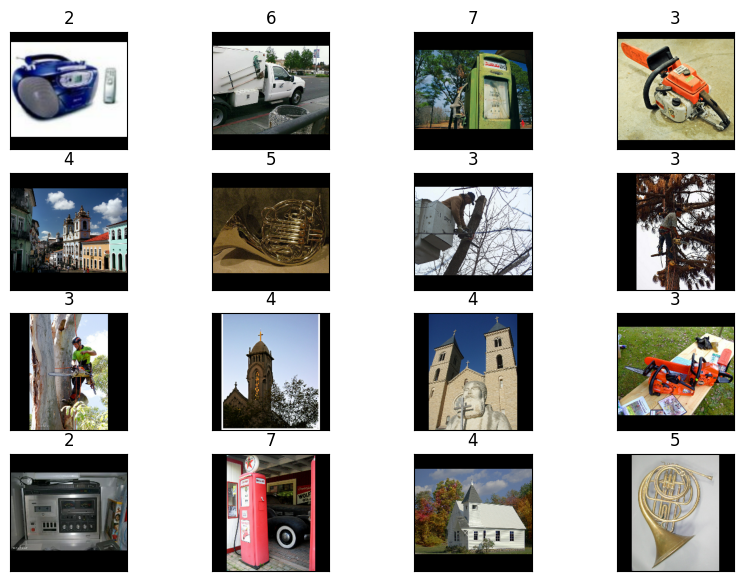

In [48]:
# Display Sample Images
def display_dataset_img(dataset):
    fig = plt.figure(figsize=(10, 7))
    i =0
    for img_batch, label_batch in dataset.take(1):
       for img in img_batch:
        label=label_batch[i]
        img = tf.cast(img,tf.uint8)
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.title.set_text(str(tf.get_static_value(label)))
        ax.imshow(img)
        i+=1

display_dataset_img(train_dataset)

# Class Activion Mapping
You can implement the class activation mapping algorithm in the code cell below.
* Try to understand the algorithm and plan out the steps required before starting to code.
* It is recommeded to use a pre-trained model: [keras pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications)
 * The keras model is easily modified to output intermediate feature maps aswell as output probabilties.  
 * Use model.summary() to print the list of layer names to identify those that you want to output.
* It is recommended to initially extract required layer weights from the model and also pass a batch of images through the model to obtain the feature vectors and output probabilities needed to produce the class activation map.
 * How to access [model weights](https://stackoverflow.com/questions/56945060/how-to-get-the-values-of-weights-and-biases-of-keras-layer) or slightly different [method](https://www.gcptutorials.com/post/how-to-get-weights-of-layers-in-tensorflow)
 * Note use of [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input) and [decode_predictions](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/decode_predictions) methods available for various pretrained models.
* You can display your final results on a 4 x 4 plot of images similar to that used in the previous code cell. (These invidual 16 images correspond to a single batch in the dataset `train_dataset` ).
* The activation map using a heat map color scheme can be overlaid on the images using matplotlib "alpha" which sets the transparancy of the image e.g. `plt.imshow(class_act_map,cmap=plt.cm.jet,alpha=0.4)`


In [51]:
# Class Activation Mapping
img_size = (HW_trg, HW_trg, 3)

# Pre-trained VGG16 model will be used (It is just personal preference, however a different trained model can also be used)
# Top classification layer are removed from the model
base_model = tf.keras.applications.vgg16.VGG16(input_shape=img_size,
                                               include_top=False,
                                               weights='imagenet')

# The following line of code will summarise VGG16 model layers
base_model.summary()

# A new model will be created from the existing VGG16 model
seq_model = Sequential()

#########################################################################################################
# The last convoulation layer in VGG16 model uses MaxPooling2D, as per the paper we need higher spatial #
# resolution, hence MaxPooling2D needs to be removed from the model. The following for loop removes the #
# the pooling layer and add the remaining layers of the model to the new sequential model               #
#########################################################################################################

for layer in base_model.layers[:-1]:
  layer.trainable = False
  seq_model.add(layer)
############################################################################################
# The paper suggests that we need to add a 3 x 3 convolution with 1024 elements before a   #
# global pooling layer, the following has been done in the following lines of code         #
############################################################################################

seq_model.add(tf.keras.layers.Conv2D(1024, (3, 3), padding = 'same', activation='relu'))

# As a new convolution layer has been added we need to complete the model so that we can train it
seq_model.add(tf.keras.layers.GlobalAvgPool2D())
seq_model.add(tf.keras.layers.Dense(1000, activation='softmax'))

seq_model.summary()

#############################################################################################
# Since we have added a new convolution layer in our model, hence we need to train the last #
# convolution layer in the model. The following line of code trains for the last layer.     #
#############################################################################################
seq_model.compile(loss='SparseCategoricalCrossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = seq_model.fit(train_dataset, epochs=3, validation_data=val_dataset)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

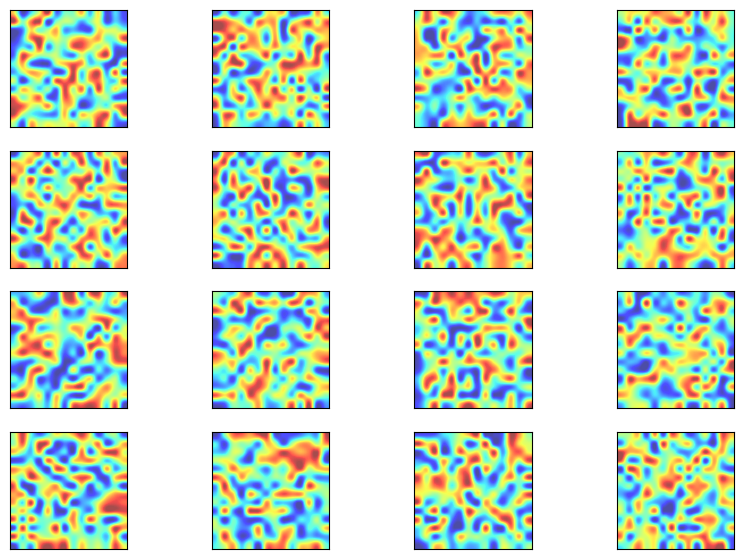

In [65]:
###################################################################################################################
# In the previous cell we have trained the model, and obtained the weights for the last convolution layer filters #
# here, first I will ignore the last two layers of the model that we have trained in order to obtain the feature  #
# maps produced by the last convolution layer.                                                                    #
###################################################################################################################
model = Model(inputs = seq_model.inputs, outputs = seq_model.layers[17].output)

model.summary()

# Obtain a batch of images and their labels from the training dataset
image_batch, label_batch = next(iter(train_dataset))

# Scale the image data as required by the VGG16 model
preprocessed_images = tf.keras.applications.vgg16.preprocess_input(image_batch)

# Pass through batch of images through the model
feature_batch = model(preprocessed_images)

# Print the output shape
print(feature_batch.shape)

#############################################################################################
# To come up with CAM for each image of the batch that is being used here, there is a need  #
# to add Global Average Pooling 2D layer to the output of the last convolution layer of the #
# model that has been constructued. The following line of code add the required layer.      #
#############################################################################################
model = Model(inputs = seq_model.inputs, outputs = seq_model.layers[18].output)

model.summary()

# I am not going to add softmax final classification layer to the model as here we are not focusing on classification
#seq_model.add(tf.keras.layers.Dense(1000, activation='softmax'))

####################################################################################################
# Let's pass through the batch of images that we have obatined from the test dataset through the   #
# modified model in order to obtain Max Averaging value corresponding to each feature map obtained #
# at the output of last convolution operation.                                                     #
####################################################################################################
global_avg_pooling_result = model(preprocessed_images)
gap_array = np.array(global_avg_pooling_result, dtype='float32')


fig = plt.figure(figsize=(10, 7))
i = 0
j = 0
rows, cols = (14, 14)
new_img = [[0]*cols]*rows
new_image = np.array(new_img, dtype='float32')
for img in feature_batch:
        for j in range (0, 1024):
          new_image += np.multiply(img[:,:,j], gap_array[i][j])
        new_image = tf.cast(new_image,tf.uint8)
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        col_img = tf.keras.utils.array_to_img(np.expand_dims(new_image, axis=2))
        ax.imshow(col_img.resize((224,224)),cmap=plt.cm.jet,alpha=0.7)
        i+=1

## Optional Task: Response of Top 5 predicted Classes to a Single Image.

You can modify Class your activation mapping algorithm to obtain Class activations for each of the Top 5 Predicted Classes for single image. This will produce similar result to [figure 4 in the paper](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) and shows how the different classes may respond to different regions in the image.

# You may Leave a note here explaining your approach/results for the e-moderator.

I have worked out the solution using the VGG16 model. As per the paper we need to remove last pooling layer and the top of the model for this piece of work. Second, for better results we need to add another convolution layer with 1024 units and filter size od 3 x 3. Afterwards, we need to add a global average pooling layer followed by a softmax classification layer.

I have modfied the model based on the above. As we have added another convolution layer, therefore it was essential to train the model to find the appropriate weights for the newly added convolution layer. Hence, I fixed the existing layers of the VGG16 model, and only trained the model for the newly added layers. The result of the model training has been shown.

As the aim of training the model was to find the weights for the newly added convoulation layer, and once that has been found we need output feature maps produced by the last convoulation layer. Hence, I amended the model and dropped out the global average pooling layer and the softmax classification layer to obtain the feature maps from the convoulation layer. A batch of images were obatined from the train data, and passed through the modified model, and the output feature maps were saved for future use.

As we require the vector produced by the global averaging pooling layer, therefore I again amended the model by adding the global average pooling layer. The same batch of train data was again passed through the amended model and the vector produced by the model (output of global average pooling layer) is stored.

Afterwards, scalar multiplication of the obtained feature map with a corresponding element of vector produced by the global average pooling layer is performed. There were 1024 feature maps corresponding to each image hence we added the scalar multiplication results of all feature maps corresponding to each figure. In each batch there were 16 imaages, hence 16 images were plotted at the end of the process.